In [1]:
import pandas as pd #importing the Pandas Library as 'pd'
import numpy as np

#Imports spatial libraries
from keplergl import KeplerGl #importing KeplerGl
import geopandas as gpd #importing geopandas as 'gpd'
from shapely.geometry import Point
from shapely.geometry import box
import shapely.wkt
from geopy.geocoders import Nominatim # Imports the geopy for the geocoding
import geojson
from geojson import Point, Feature, FeatureCollection, dump
from geojson_rewind import rewind



import xml.etree.ElementTree as ET
import requests
import matplotlib.pyplot as plt


from time import time

# Introduction
This notebook analyses which parts of the city that have lower income levels are not within 10 minutes of affordable food initative provision.
It is work in progress and should not be quoted. It requires the other notebook in the container to be run first.

# Takes the food outlet locations, calculate 10 minute isochrone and convert to geojson

In [2]:
## Reads in the Liverpool boundary file
filename='Data/Out/Liverpool_boundary.geojson'
file = open(filename)
Liverpool_boundary = gpd.read_file(file)

In [3]:
filename = "Data/Out/Affordable_food_iniatives.geojson"

file = open(filename)
Affordable_food_outlets = gpd.read_file(file)

In [4]:
# Characteristics for API calls to calculate 10 minute walking time

urlBase = 'https://api.mapbox.com/isochrone/v1/mapbox/'
profile = 'walking/'
minutes = 10
mapboxglaccessToken = 'pk.eyJ1Ijoiam9obmFyZGF2aWVzIiwiYSI6ImNpeHRmZjhlYjAwMmUycW9qbHRvem0xa3gifQ.oQ9cnn8b5HATalxv9rppYg'


# Function to make calls to the mapbox isochrone apis
def isochrone_api(x):
   api_call=urlBase+profile +str(x['lon'])+','+str(x['lat'])+'?contours_minutes='+str(minutes)+'&polygons=true&access_token='+mapboxglaccessToken
   try:
    walk_dist=requests.get(api_call)
    walk_iso= walk_dist.json()['features'][0]
   except:
    walk_iso="call_failed"
   return walk_iso

In [5]:
# Call the isochrone API for each of the food output locations
Affordable_food_outlets['walking_dist']=Affordable_food_outlets.apply(isochrone_api,axis=1)

In [6]:
# Take the outputs and turn into json
travel_distances = FeatureCollection(Affordable_food_outlets['walking_dist'].values.tolist())

In [7]:
# Ensures geojson follows the right handed rule
travel_distances= rewind(travel_distances)

In [8]:
# Convert to geopandas data frame
travel_distances = gpd.GeoDataFrame.from_features(travel_distances["features"])

In [9]:
# Set projection
travel_distances= travel_distances.set_crs("EPSG:4326")

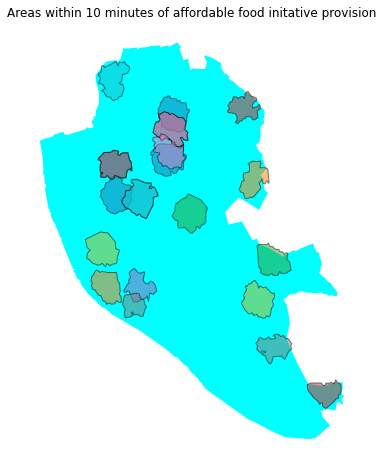

In [23]:
# Check it plots
ax =  Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns off the axis
plt.title("Areas within 10 minutes of affordable food initative provision")
travel_distances.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax);

In [24]:
# Export
with open('Data/Out/Isochrone.geojson', 'w') as f:
   dump(travel_distances, f)

# Identify areas with higher levels of deprivation which have lower levels of access

In [25]:
filename="Data/Out/Liverpool_lsoa.geojson"
    
file = open(filename)
Lsoa_multdep = gpd.read_file(file)

<AxesSubplot:>

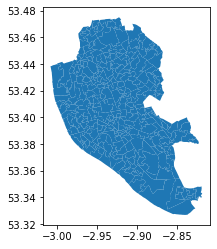

In [26]:
Lsoa_multdep.plot()

In [27]:
# List the variables
list(Lsoa_multdep)

['LSOA11CD',
 'LSOA11NM',
 'LSOA code (2011)',
 'LSOA name (2011)_x',
 'Local Authority District code (2019)_x',
 'Local Authority District name (2019)_x',
 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)',
 'LSOA name (2011)_y',
 'Local Authority District code (2019)_y',
 'Local Authority District name (2019)_y',
 'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 

In [28]:
# Select the areas in the city in the lowest income quintile
Lower_income=Lsoa_multdep[Lsoa_multdep['Income Domain numerator_rank']==5]

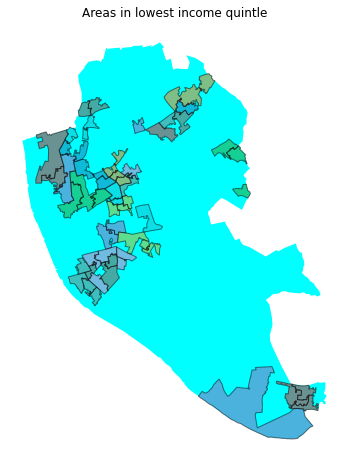

In [29]:
ax = Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns off the axis
plt.title("Areas in lowest income quintle")
Lower_income.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax);

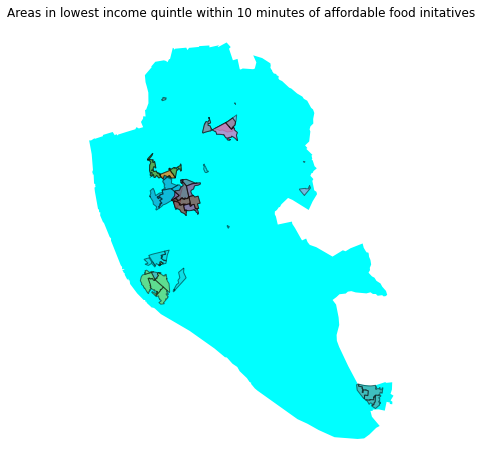

In [30]:
#Lower income levels within 10 minutes of affordable food initative provision
lower_income_withaccess = gpd.overlay(Lower_income, travel_distances, how='intersection')
ax = Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns off the axis
plt.title("Areas in lowest income quintle within 10 minutes of affordable food initatives")
lower_income_withaccess.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax);

Text(0.5, 1.0, 'Areas in lowest income quintiles not within 10 minutes of affordable food initative provision')

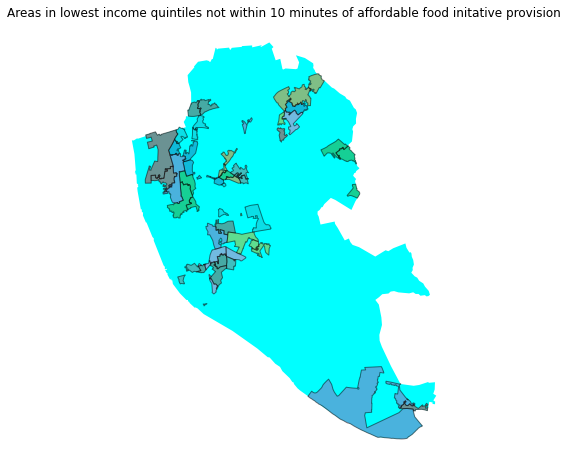

In [31]:
#Lower income levels not within 10 minutes of affordable food initative provision

lower_income_withoutaccess = gpd.overlay(Lower_income, travel_distances, how='difference')

ax = Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns the axis off
lower_income_withoutaccess.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax)
plt.title("Areas in lowest income quintiles not within 10 minutes of affordable food initative provision")


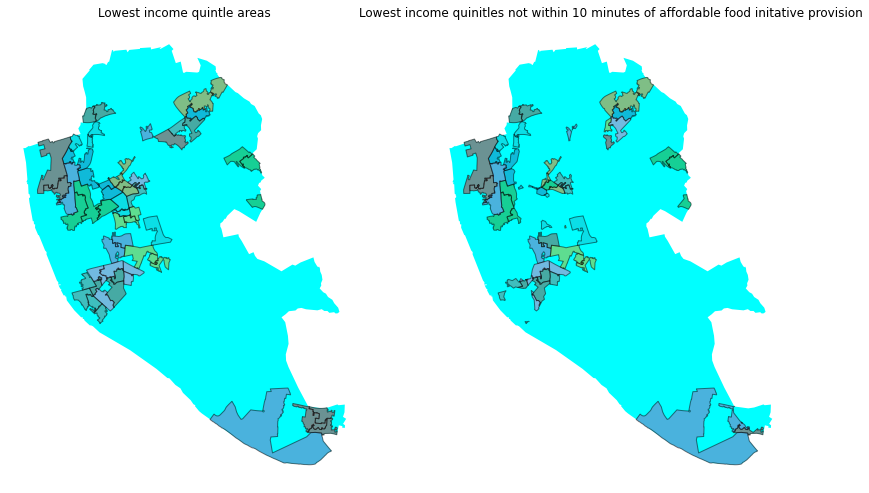

In [33]:
# Plots the lowest income quintile areas and those areas not within 10 minutes of affordable provision side by side

plt.figure(1, figsize=(14,26))
ax1 = plt.subplot(221)
Liverpool_boundary.plot(color='cyan', figsize=(6,13), ax=ax1)
ax1.axis('off') # Turns the axis off
Lower_income.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax1)
plt.title("Lowest income quintle areas")

ax2 = plt.subplot(222)
Liverpool_boundary.plot(color='cyan',figsize=(6,13), ax=ax2)
ax2.axis('off') # Turns off the axis
ax2.set_title("Lowest income quinitles not within 10 minutes of affordable food initative provision")
lower_income_withoutaccess.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax2);